In [2]:
import os
import re
from itertools import chain
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer, set_seed
from datasets import load_dataset

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


set_seed(42)

In [3]:
class Seq2SeqDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device):
        super(Seq2SeqDataset, self).__init__()
        
        self.bert_tokenizer = bert_tokenizer
        self.gpt_tokenizer = gpt_tokenizer
        self.bert_device = bert_device
        self.gpt_device = gpt_device
        
        self.sent1, self.sent2 = self.create_pair_dataset(dataset)
        
    def __getitem__(self, i):
        bert_sent1 = self.bert_tokenizer(self.sent1[i], padding='max_length', truncation=True, return_tensors='pt')
        gpt_sent2 = self.gpt_tokenizer(self.sent2[i], padding='max_length', truncation=True, return_tensors='pt')
        
        bert_sent1 = {k: v.squeeze().to(self.bert_device) for k, v in bert_sent1.items()}
        gpt_sent2 = {k: v.squeeze().to(self.gpt_device) for k, v in gpt_sent2.items()}
        
        return bert_sent1, gpt_sent2
    
    def __len__(self):
        return len(self.sent1)
    
    def create_tokenized_pairs(self, x):
        sentences = re.split(r'[\s]*#Person\d#: ', x['dialogue'])[1:]

        sentences1 = sentences[:-1]
        sentences2 = list(map(lambda x: self.gpt_tokenizer.bos_token + x + self.gpt_tokenizer.eos_token, sentences[1:]))

        return {'sent1': sentences1, 'sent2': sentences2}
    
    def create_pair_dataset(self, dataset):
        tokenized_dataset = dataset.map(self.create_tokenized_pairs)

        flatten_sent1 = [sent for sents in tokenized_dataset['sent1'] for sent in sents]
        flatten_sent2 = [sent for sents in tokenized_dataset['sent2'] for sent in sents]

        df = pd.DataFrame({'sent1':flatten_sent1,'sent2':flatten_sent2}).drop_duplicates()
        
        return df['sent1'].tolist(), df['sent2'].tolist()


In [5]:
def get_bert_model_tokenizer(path, model_max_length, bert_device):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', model_max_length=model_max_length)
    model = AutoModel.from_pretrained(path)
    
    return model.to(bert_device), tokenizer


def get_gpt_model_tokenizer(path, model_max_length, gpt_device):
    special_tokens = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 
                      'unk_token': '<UNK>', 'pad_token': '<PAD>'}
    
    tokenizer = AutoTokenizer.from_pretrained('gpt2', model_max_length=model_max_length)
    tokenizer.add_special_tokens(special_tokens)
    
    model = AutoModelForCausalLM.from_pretrained(path, add_cross_attention=True)
    model.resize_token_embeddings(len(tokenizer))
    model.config.add_cross_attention = True
    model.config.is_decoder = True
    
    return model.to(gpt_device), tokenizer


In [7]:
max_len = 50
bert_device=torch.device('cpu')
gpt_device=torch.device('cpu')

bert_encoder, bert_tokenizer = get_bert_model_tokenizer('bert-base-cased', max_len, bert_device)
gpt_decoder, gpt_tokenizer = get_gpt_model_tokenizer('gpt2', max_len, gpt_device)

train_data = load_dataset('knkarthick/dialogsum', split='train')
train_dataset = Seq2SeqDataset(train_data, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.11.crossattention.c_proj.weight', 'h.3.

  0%|          | 0/12460 [00:00<?, ?ex/s]

In [12]:
sent1, sent2 = train_dataset[2]
bert_tokenizer.decode(sent1['input_ids']), gpt_tokenizer.decode(sent2['input_ids'])

("[CLS] Yes, well, you haven't had one for 5 years. You should have one every year. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 '<BOS>I know. I figure as long as there is nothing wrong, why go see the doctor?<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>')

In [5]:
def get_dataloader(bs, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device):
    train_data = load_dataset('knkarthick/dialogsum', split='train')
    val_data = load_dataset('knkarthick/dialogsum', split='validation')

    train_dataset = Seq2SeqDataset(train_data, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)
    val_dataset = Seq2SeqDataset(val_data, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)
    
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
    
    return train_dataloader, val_dataloader

In [6]:
class Seq2SeqModel:
    def __init__(self, bert_model, gpt_model, bert_tokenizer, gpt_tokenizer):
        self.bert_model = bert_model
        self.gpt_model = gpt_model
        self.bert_tokenizer = bert_tokenizer
        self.gpt_tokenizer = gpt_tokenizer
        
    def train_step(self, dataloader, optimizer):
        self.bert_model.train(), self.gpt_model.train()
        losses = []

        pbar = tqdm(dataloader)
        for i, (x, y) in enumerate(pbar):
            optimizer.zero_grad()
            bert_out = self.bert_model(**x)
            gpt_out = self.gpt_model(**y, labels=y['input_ids'], 
                                     encoder_hidden_states=bert_out.last_hidden_state.to(self.gpt_model.device))
            loss = gpt_out.loss
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            pbar.set_description(f'Batch Loss: {np.mean(losses):.5f}')
        
        return np.mean(losses)
        
    def eval_step(self, dataloader):
        self.bert_model.eval(), self.gpt_model.eval()
        losses = []

        pbar = tqdm(dataloader)
        for i, (x, y) in enumerate(pbar):
            bert_out = self.bert_model(**x)
            gpt_out = self.gpt_model(**y, labels=y['input_ids'], 
                                     encoder_hidden_states=bert_out.last_hidden_state.to(self.gpt_model.device))
            loss = gpt_out.loss

            losses.append(loss.item())
            pbar.set_description(f'Batch Loss: {np.mean(losses):.5f}')
        
        return np.mean(losses)
    
    def answer(self, sent):
        with torch.no_grad():
            tokenized_sent = self.bert_tokenizer(sent, padding='max_length', 
                                                 truncation=True, return_tensors='pt')
            tokenized_ans = self.gpt_tokenizer(self.gpt_tokenizer.bos_token, return_tensors='pt')

            tokenized_sent = {k: v.to(self.bert_model.device) for k, v in tokenized_sent.items()}
            tokenized_ans = {k: v.to(self.gpt_model.device) for k, v in tokenized_ans.items()}
            
            bert_out = self.bert_model(**tokenized_sent)
            gpt_out = self.gpt_model.generate(**tokenized_ans, max_new_tokens=30, temperature=0.9, 
                                              encoder_hidden_state=bert_out.last_hidden_state)

            return self.gpt_tokenizer.decode(gpt_out[0])

    def save(self, model_dir):
        os.makedirs(model_dir, exist_ok=True)
        self.bert_model.save_pretrained(os.path.join(model_dir, 'bert_encoder'))
        self.gpt_model.save_pretrained(os.path.join(model_dir, 'gpt_decoder'))
        

In [7]:
max_len = 50
bert_device=torch.device('cuda:0')
gpt_device=torch.device('cuda:1')
bs = 4
lr = 1e-5

In [8]:
bert_encoder, bert_tokenizer = get_bert_model_tokenizer('/kaggle/input/bertgpt2bestmodel/bert_gpt_1_1/bert_encoder', max_len, bert_device)
gpt_decoder, gpt_tokenizer = get_gpt_model_tokenizer('/kaggle/input/bertgpt2bestmodel/bert_gpt_1_1/gpt_decoder', max_len, gpt_device)

train_loader, val_loader = get_dataloader(bs, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)
opt = optim.Adam(chain(gpt_decoder.parameters(), bert_encoder.parameters()), lr=lr)

seq2seq_model = Seq2SeqModel(bert_encoder, gpt_decoder, bert_tokenizer, gpt_tokenizer)


df = pd.DataFrame(columns=['Training Loss', 'Validation Loss'])
df.at[0, 'Validation Loss'] = 0.99507

for e in range(1, 5):
    print(df)
    
    train_loss = seq2seq_model.train_step(train_loader, opt)
    val_loss = seq2seq_model.eval_step(val_loader)

    df.at[e, 'Training Loss'] = train_loss
    df.at[e, 'Validation Loss'] = val_loss

    clear_output(wait=True)

    seq2seq_model.save(f'bert_gpt2_epoch_{e}')


  Training Loss Validation Loss
0           NaN         0.99507
1      0.993247          0.9565
2      0.930136        0.939213
3      0.877437        0.930218


  0%|          | 0/23583 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

In [11]:
!zip -r bert_gpt2_epoch3.zip /kaggle/working/bert_gpt2_epoch_3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/bert_gpt2_epoch_3/ (stored 0%)
  adding: kaggle/working/bert_gpt2_epoch_3/gpt_decoder/ (stored 0%)
  adding: kaggle/working/bert_gpt2_epoch_3/gpt_decoder/config.json (deflated 51%)
  adding: kaggle/working/bert_gpt2_epoch_3/gpt_decoder/pytorch_model.bin (deflated 11%)
  adding: kaggle/working/bert_gpt2_epoch_3/bert_encoder/ (stored 0%)
  adding: kaggle/working/bert_gpt2_epoch_3/bert_encoder/config.json (deflated 48%)
  adding: kaggle/working/bert_gpt2_epoch_3/bert_encoder/pytorch_model.bin (deflated 7%)


<AxesSubplot:>

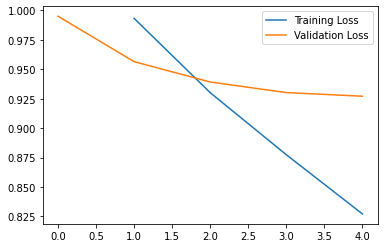

In [12]:
df.plot()